In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
import pandas as pd

In [2]:
class Node:
    """Reprezentacja węzła w grafie.

    Klasa ta została utworzona w celu rozróżnienia w grafie dwóch (lub większej liczby) węzłów
    o tej samej etykiecie, np. umożliwia utworzenie dwóch oddzielnych węzłów o etykiecie 'x'.
    """
    def __init__(self, label):
        """Inicjuje obiekt Node odpowiednią wartością pola label."""
        self.label = label

    def __str__(self):
        """Nadpisuje metodę __str__ z klasy object.

        Pozwala na wypisanie wartości pola label jako etykieta węzła na grafie.
        """
        return str(self.label)

In [3]:
def get_polynomial_graph(coefficients_list, increasing_degree=False):
    """Tworzy graf wielomianu.

    Do zbudowania grafu wykorzystuje networkx.Digraph.

    Arguments:
        coefficients_list: Lista współczynników wielomianu.
        increasing_degree: Opcjonalnie; Pozostawia użytkownikowi wybór, czy współczynniki
            wielomianu zostaną podane od współczynnika przy najwyższej potędze zmiennej
            do wyrazu wolnego wielomianu (ustawienie domyślne), czy odwrotnie.

    Returns:
        Graf wielomianu w postaci obiektu typu networkx.Digraph.
    """

    # tworzy kopię listy współczynników, aby nie modyfikować oryginalnej listy
    coefs_list = coefficients_list[:]

    if increasing_degree:
        # jeśli współczynniki są podane od wyrazu wolnego do współczynnika przy najwyższej
        # potędze zmiennej, to lista współczynników zostaje odwrócona
        coefs_list.reverse()

    while len(coefs_list) > 0 and coefs_list[0] == 0:
        # współczynnik przy najwyższej potędze zmiennej nie może być zerem
        coefs_list.remove(coefs_list[0])

    # ustalenie liczby współczynników wielomianu
    number_of_coefs = len(coefs_list)
    if number_of_coefs == 0:
        # jeśli lista współczynników jest pusta, to wyrażenie ma postać W(x) = 0
        return get_zero_graph()

    # ustalenie stopnia wielomianu
    polynomial_degree = last_nonzero_coef_idx = number_of_coefs - 1
    # ustalenie indeksu ostatniego niezerowego współczynnika wielomianu
    for i in range(number_of_coefs - 1, -1, -1):
        if coefs_list[i] != 0:
            break
        last_nonzero_coef_idx -= 1

    # utworzenie podstawy grafu wielomianu
    graph = nx.DiGraph()
    base_node = Node("=")
    graph.add_node(base_node)

    for i in range(last_nonzero_coef_idx):
        # dodanie do grafu węzłów odpowiednich dla danych współczynników wielomianu
        # (wszystkich oprócz ostatniego niezerowego węzła)

        if coefs_list[i] == 0:
            # jeżeli współczynnik jest równy 0, to nie dodajemy go do wielomianu
            continue

        # utworzenie węzła '+', aby w kolejnej iteracji móc dołączyć do niego
        # kolejne elementy wielomianu
        new_base_node = Node("+")
        graph.add_edge(base_node, new_base_node)
        base_node = new_base_node

        coefficient_node = Node(coefs_list[i])
        multiply_node = Node("*")
        degree = polynomial_degree - i
        graph.add_edge(base_node, multiply_node)
        graph.add_edge(multiply_node, coefficient_node)
        if degree > 1:
            graph.add_edge(multiply_node, Node(f"x^{degree}"))
        elif degree == 1:
            graph.add_edge(multiply_node, Node(f"x"))

    # sprawdzenie potęgi zmiennej przy ostatnim niezerowym współczynniku wielomianu
    last_degree = polynomial_degree - last_nonzero_coef_idx
    if last_degree > 0:
        multiply_node = Node("*")
        graph.add_edge(base_node, multiply_node)
        graph.add_edge(multiply_node, Node(coefs_list[last_nonzero_coef_idx]))
        if last_degree > 1:
            graph.add_edge(multiply_node, Node(f"x^{last_degree}"))
        else:
            graph.add_edge(multiply_node, Node(f"x"))
    else:
        # jeśli last_degree wynosi 0, to dodajemy do grafu wyraz wolny wielomianu
        graph.add_edge(base_node, Node(coefs_list[last_nonzero_coef_idx]))

    return graph


def get_zero_graph():
    """Tworzy graf wyrażenia W(x) = 0.

    Returns:
        Graf wyrażenia W(x) = 0 w postaci obiektu typu networkx.DiGraph.
    """
    graph = nx.DiGraph()
    graph.add_edge(Node("="), Node(0))
    return graph

In [4]:
def get_intercept_form_graph(coefficient, roots_list):
    """Tworzy graf wielomianu w postaci iloczynowej.

    Arguments:
        coefficient: Współczynnik wielomianu przy najwyższej potędze zmiennej.
        roots_list: Lista miejsc zerowych wielomianu.

    Returns:
        Graf postaci iloczynowej wielomianu w postaci obiektu typu networkx.Digraph.
    """

    if coefficient == 0:
        # jeśli współczynnik przy najwyższej potędze zmiennej wielomianu wynosi zero,
        # to całość upraszcza się do formy W(x) = 0
        return get_zero_graph()

    # utworzenie podstawy grafu wielomianu
    graph = nx.DiGraph()
    base_node = Node("=")
    graph.add_node(base_node)

    # dodanie do grafu współczynnika przy najwyższej potędze zmiennej wielomianu
    multiply_node = Node("*")
    graph.add_edge(base_node, multiply_node)
    base_node = multiply_node
    graph.add_edge(base_node, Node(coefficient))

    for i in range(len(roots_list) - 1):
        # oznaczanie kolejnych miejsc zerowych na grafie wielomianu
        multiply_node = Node("*")
        graph.add_edge(base_node, multiply_node)
        base_node = multiply_node

        root = roots_list[i]
        if root == 0:
            # jeśli miejsce zerowe wynosi 0, to na grafie rysowana jest jedynie zmienna x
            graph.add_edge(base_node, Node('x'))
        else:
            minus_node = Node("-")
            graph.add_edge(base_node, minus_node)
            graph.add_edge(minus_node, Node("x"))
            graph.add_edge(minus_node, Node(root))

    # dodanie ostatniego miejsca zerowego do grafu wielomianu
    root = roots_list[-1]
    if root == 0:
        # jeśli miejsce zerowe wynosi 0, to na grafie rysowana jest jedynie zmienna x
        graph.add_edge(base_node, Node('x'))
    else:
        minus_node = Node("-")
        graph.add_edge(base_node, minus_node)
        graph.add_edge(minus_node, Node("x"))
        graph.add_edge(minus_node, Node(root))

    return graph

In [5]:
def get_polynomial_roots_graph(coefficients_list, increasing_degree=False):
    """Tworzy graf wielomianu w postaci iloczynowej.

        Do zbudowania grafu wykorzystuje networkx.Digraph.

        Arguments:
            coefficients_list: Lista współczynników wielomianu.
            increasing_degree: Opcjonalnie; Pozostawia użytkownikowi wybór, czy współczynniki
                wielomianu zostaną podane od współczynnika przy najwyższej potędze zmiennej
                do wyrazu wolnego wielomianu (ustawienie domyślne), czy odwrotnie.

        Returns:
            Graf postaci iloczynowej wielomianu w postaci obiektu typu networkx.Digraph.
        """

    # tworzy kopię listy współczynników, aby nie modyfikować oryginalnej listy
    coefs_list = coefficients_list[:]

    if increasing_degree:
        # jeśli współczynniki są podane od wyrazu wolnego do współczynnika przy najwyższej
        # potędze zmiennej, to lista współczynników zostaje odwrócona
        coefs_list.reverse()

    while len(coefs_list) > 0 and coefs_list[0] == 0:
        # współczynnik przy najwyższej potędze zmiennej nie może być zerem
        coefs_list.remove(coefs_list[0])

    # ustalenie liczby współczynników wielomianu
    num_of_coefficients = len(coefs_list)

    if num_of_coefficients in (0, 1):
        # wyrażenie bez miejsc zerowych
        return get_zero_graph()
    elif num_of_coefficients == 2:
        # równanie liniowe
        roots = solve_linear(coefs_list)
    elif num_of_coefficients == 3:
        # równanie kwadratowie
        roots = solve_quadratic(coefs_list)
    else:
        # wielomian
        roots = solve_polynomial(coefs_list)

    return get_intercept_form_graph(coefs_list[0], roots)


def solve_linear(coefficients_list):
    """Rozwiązuje równanie liniowe.

    Arguments:
        coefficients_list: Lista współczynników równania liniowego.

    Returns:
        Graf postaci iloczynowej wielomianu w postaci obiektu typu networkx.Digraph.
    """
    a, b = coefficients_list
    # wyznaczenie miejsca zerowego
    x0 = - b / a
    return [x0]


def solve_quadratic(coefficients_list):
    """Rozwiązuje równanie kwadratowe.

    Attributes:
        coefficients_list: Lista współczynników równania kwadratowego.

    Returns:
        Graf postaci iloczynowej wielomianu w postaci obiektu typu networkx.Digraph.
    """
    a, b, c = coefficients_list
    delta = b ** 2 - 4 * a * c
    # odpowiednie wyznaczenie miejsc zerowych
    if delta > 0:
        # dwa różne rzeczywiste miejsca zerowe
        sqrt_delta = delta ** (1 / 2)
        x1 = (-b - sqrt_delta) / (2 * a)
        x2 = (-b + sqrt_delta) / (2 * a)
        roots = [x1, x2]
    elif delta == 0:
        # jedno podwójne rzeczywiste miejsce zerowe
        x0 = -b / (2 * a)
        roots = [x0, x0]
    else:
        # brak rozwiązań rzeczywistych - wyznaczenie miejsc zerowych w ciele liczb zespolonych
        roots = solve_polynomial(coefficients_list)

    return roots


def solve_polynomial(coefficients_list):
    """Rozwiązuje wielomian.

    Attributes:
        coefficients_list: Lista współczynników wielomianu.

    Returns:
        Graf postaci iloczynowej wielomianu w postaci obiektu typu networkx.Digraph.
    """

    # tworzy kopię listy współczynników, aby nie modyfikować oryginalnej listy
    coefs_list = coefficients_list[:]

    # dostosowuje listę współczynników
    # i wyznacza miejsca zerowe przy pomocy biblioteki numpy.polynomial
    coefs_list.reverse()
    polynomial = Polynomial(coefs_list)
    roots = polynomial.roots()
    # zaokrągla otrzymane miejsca zerowe do dwóch miejsc po przecinku
    roots = [round(num, 2) for num in roots]

    return roots

In [6]:
def draw_polynomial_graph(graph):
    """Rysuje podany graf wielomianu.

    Do rysowania wykorzystuje networkx.draw.

    Arguments:
        graph: Graf wielomianu w postaci obiektu typu networkx.DiGraph.
    """

    # utworzenie słownika określającego odległości między węzłami grafu
    df = pd.DataFrame(index=graph.nodes(), columns=graph.nodes())
    for row, data in nx.shortest_path_length(graph):
        for col, dist in data.items():
            df.loc[row, col] = dist

    df = df.fillna(df.max().max() / 3)

    # rysowanie grafu
    nx.draw(graph, node_size=1000, pos=nx.kamada_kawai_layout(graph, dist=df.to_dict()), with_labels=True)

In [7]:
def save_polynomial_graph(filename, coefficients_list, increasing_degree=False):
    """Zapisuje graf wielomianu w formacie PNG.

    Arguments:
        filename: Nazwa pliku docelowego (bez rozszerzenia).
        coefficients_list: Lista współczynników rysowanego wielomianu.
        increasing_degree: Opcjonalnie; Pozostawia użytkownikowi wybór, czy współczynniki
            wielomianu zostaną podane od współczynnika przy najwyższej potędze zmiennej
            do wyrazu wolnego wielomianu (ustawienie domyślne), czy odwrotnie.
    """

    # przygotowanie figury do rysowania
    figure = plt.figure()
    figure.set_figheight(8)
    figure.set_figwidth(15)

    # utworzenie i rysowanie grafu wielomianu w postaci ogólnej
    eq_graph = get_polynomial_graph(coefficients_list, increasing_degree=increasing_degree)
    figure.add_subplot(1, 2, 1)
    draw_polynomial_graph(eq_graph)

    # utworzenie i rysowanie grafu wielomianu w postaci iloczynowej
    res_graph = get_polynomial_roots_graph(coefficients_list, increasing_degree=increasing_degree)
    figure.add_subplot(1, 2, 2)
    draw_polynomial_graph(res_graph)

    # zapis otrzymanej figury do pliku PNG
    filename = filename + '.png'
    figure.savefig(filename)

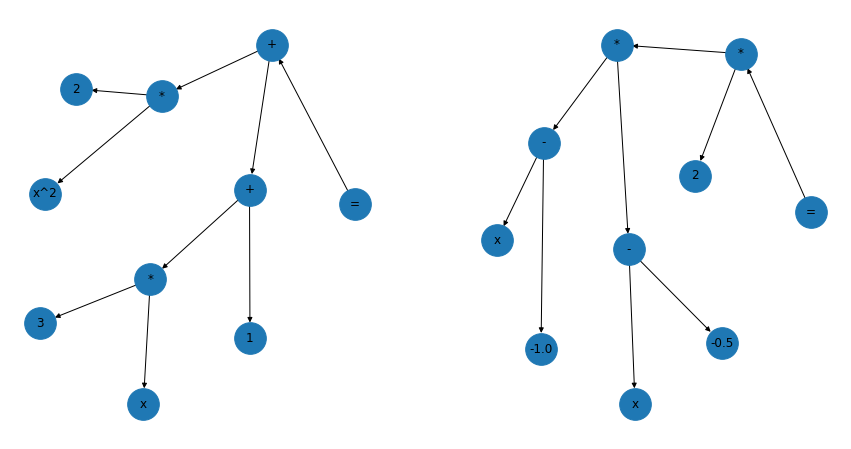

In [8]:
# [2, 3, 1]
# 2x^2 + 3x + 1 = 0
# x1 = -1; x2 = -0.5
coefficients = [2, 3, 1]
save_polynomial_graph("figure1", coefficients)

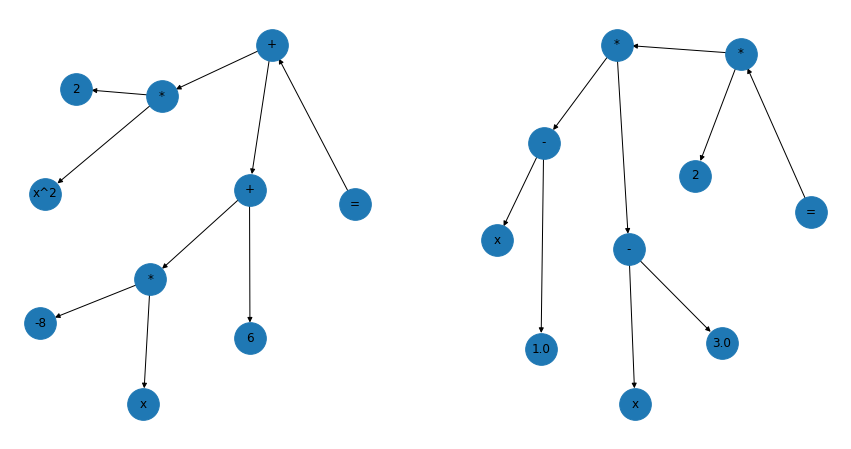

In [9]:
# [6, -8, 2]
# 6 + (-8)x + 2x^2
# x1 = 1; x2 = 3
coefficients = [6, -8, 2]
save_polynomial_graph("figure2", coefficients, increasing_degree=True)

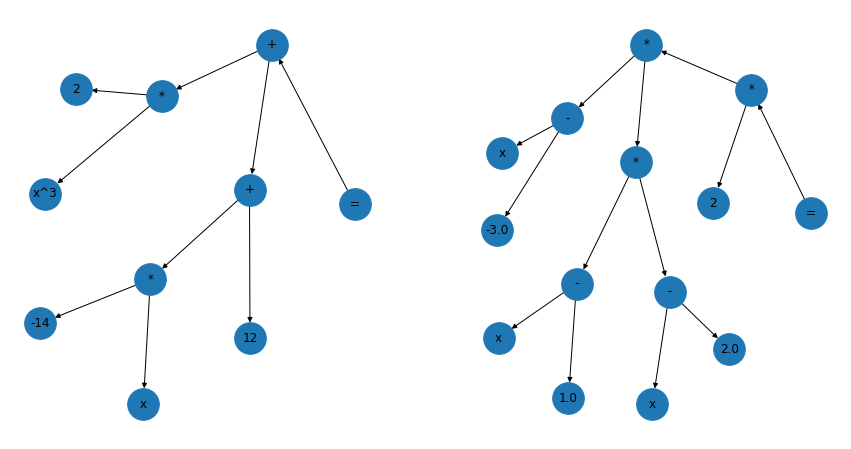

In [10]:
# [2, 0, -14, 12]
# 2x^3 - 14x + 12
# 1, -3, 2
coefficients = [2, 0, -14, 12]
save_polynomial_graph("figure3", coefficients)

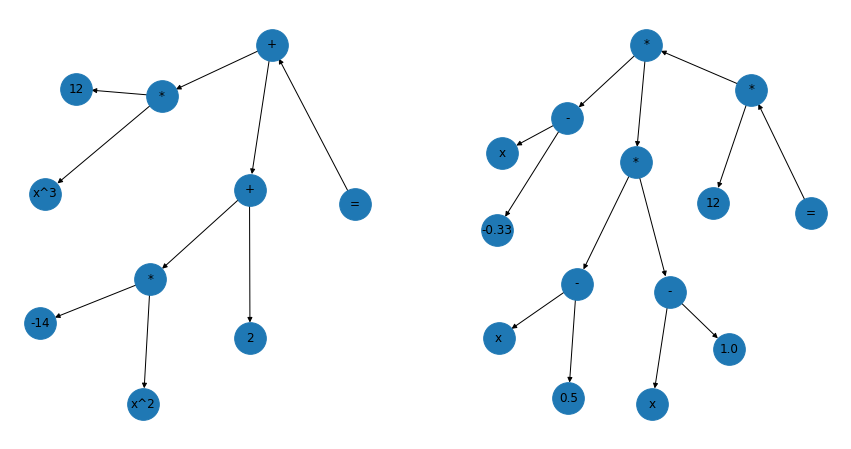

In [11]:
# [2, 0, -14, 12]
# 2 + (-14)x^2 + 12x^3
# -0.33, 0.5, 1
coefficients = [2, 0, -14, 12]
save_polynomial_graph("figure4", coefficients, increasing_degree=True)